In [15]:
import numpy as np
import pandas as pd
import yfinance as yf   

## BSE Tickers:
- **JM Financial**: 523405.BO
- **Asian Paints**: 500820.BO
- **Dabur**: 500096.BO
- **ICICI Bank**: 532174.BO
- **Tata Motors**: 500570.BO

### Define tickers for the stocks and the market index

In [16]:
stock_tickers = ['JMFINANCIL.NS', 'ASIANPAINT.NS', 'DABUR.NS', 'ICICIBANK.NS', 'TATAMOTORS.NS']
market_ticker = '^BSESN'  # BSE Sensex

### Function to import stock data

In [17]:
def import_stock_data(tickers, start='2019-01-01', end='2024-01-01'):
    data = yf.download(tickers, start=start, end=end)['Adj Close']
    return data

### Function to compute beta

In [18]:
def compute_beta(data, stock, market):
    log_returns = np.log(data / data.shift(1))
    cov = log_returns.cov() * 1260  # Annualize by multiplying by 1260 (5 years of trading days)
    cov_w_market = cov.loc[stock, market]
    market_var = log_returns[market].var() * 1260  # Annualize market variance
    return cov_w_market / market_var

### Function to compute CAPM return

In [19]:
def compute_annualized_return(data, stock):
    daily_returns = data[stock].pct_change().dropna()
    mean_daily_return = daily_returns.mean()
    annualized_return = (1 + mean_daily_return) ** 1260 - 1  # Annualize daily return for 5 years
    return annualized_return

def compute_capm(data, stock, market, riskfree=0.0625):
    beta = compute_beta(data, stock, market)
    annualized_return = compute_annualized_return(data, market)
    return riskfree + beta * (annualized_return - riskfree)

### Function to compute Sharpe Ratio

In [20]:
def compute_sharpe(data, stock, market, riskfree=0.0625):
    log_returns = np.log(data / data.shift(1))
    ret = compute_capm(data, stock, market, riskfree)
    return (ret - riskfree) / (log_returns[stock].std() * np.sqrt(1260))  # Annualize daily standard deviation for 5 years


### Function to compute Sortino Ratio

In [21]:
def compute_sortino(data, stock, riskfree=0.0625):
    log_returns = np.log(data / data.shift(1))
    downside_returns = log_returns[log_returns < 0]
    expected_return = log_returns[stock].mean() * 1260  # Annualize daily return for 5 years
    downside_std = downside_returns[stock].std() * np.sqrt(1260)  # Annualize downside standard deviation for 5 years
    return (expected_return - riskfree) / downside_std

### Function to compute VaR

In [22]:
z_score_95 = 1.96  # Z-score for 95% confidence level

def compute_var(data, stock, z_score=z_score_95):
    log_returns = np.log(data / data.shift(1))
    sigma = log_returns[stock].std()  # Standard deviation of daily returns
    var = z_score * sigma * np.sqrt(1)  # VaR for 1 day
    annualized_var = var * np.sqrt(1260)  # Annualize the daily VaR
    return annualized_var

### Function to compute CAPM metrics for a stock

In [23]:
def stock_CAPM(stock_ticker, market_ticker, start_date='2019-01-01', riskfree=0.025):
    data = import_stock_data([stock_ticker, market_ticker], start=start_date)
    beta = compute_beta(data, stock_ticker, market_ticker)
    capm = compute_capm(data, stock_ticker, market_ticker, riskfree)
    sharpe = compute_sharpe(data, stock_ticker, market_ticker, riskfree)
    sortino = compute_sortino(data, stock_ticker, riskfree)
    var = compute_var(data, stock_ticker)
    capmdata = pd.DataFrame([beta, capm, sharpe, sortino, var], columns=[stock_ticker], index=['Beta', 'Return', 'Sharpe', 'Sortino', 'VaR'])
    return capmdata.T

In [24]:
data=import_stock_data('JMFINANCIL.NS', start='2019-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed

In [25]:
data.columns = ['JMFINANCIL.NS']

In [26]:
data

Date
2019-01-01    83.715897
2019-01-02    80.964447
2019-01-03    80.874252
2019-01-04    81.280190
2019-01-07    81.370399
                ...    
2023-12-22    94.960854
2023-12-26    94.327461
2023-12-27    97.396996
2023-12-28    95.350639
2023-12-29    95.789146
Name: Adj Close, Length: 1235, dtype: float64

In [27]:
# Compute metrics for each stock
results = pd.DataFrame()
for stock in stock_tickers:
    results = pd.concat([results, stock_CAPM(stock, market_ticker)])

print(results)

[*********************100%%**********************]  2 of 2 completed
C:\Users\asus\AppData\Local\Temp\ipykernel_7672\2007383067.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data[stock].pct_change().dropna()
[*********************100%%**********************]  2 of 2 completed
C:\Users\asus\AppData\Local\Temp\ipykernel_7672\2007383067.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data[stock].pct_change().dropna()
[*********************100%%**********************]  2 of 2 completed
C:\Users\asus\AppData\Local\Temp\ipykernel_7672\2007383067.py:2: FutureWa

                   Beta    Return    Sharpe   Sortino       VaR
JMFINANCIL.NS  0.948377  1.183944  1.210708  0.172282  1.876200
ASIANPAINT.NS  0.705767  0.887467  1.461406  2.124984  1.156719
DABUR.NS       0.547158  0.693642  1.310218  0.838728  1.000244
ICICIBANK.NS   1.339767  1.662233  2.216078  1.761133  1.448043
TATAMOTORS.NS  1.360753  1.687879  1.562645  2.044293  2.085722



C:\Users\asus\AppData\Local\Temp\ipykernel_7672\2007383067.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data[stock].pct_change().dropna()


[*********************100%%**********************]  5 of 5 completed


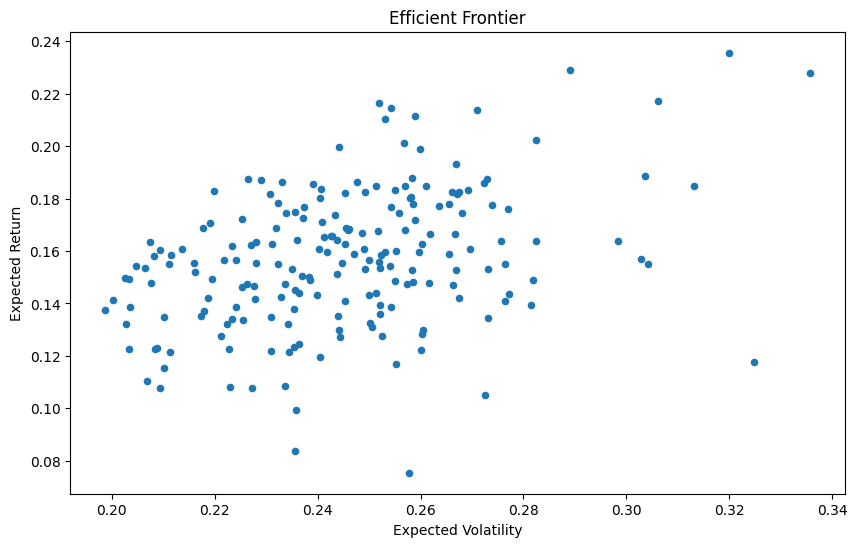

Expected Portfolio Return: 16.1%
Expected Portfolio Variance: 5.54%
Expected Portfolio Volatility: 23.53%


In [33]:
import matplotlib.pyplot as plt
# Import the data
data = import_stock_data(stock_tickers)

# Calculate log returns
log_returns = np.log(data / data.shift(1))

# Number of assets
num_assets = len(stock_tickers)

# Initialize lists to store portfolio returns and volatilities
pfolio_returns = []
pfolio_volatilities = []

# Generate random portfolio weights
for x in range(200):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    pfolio_returns.append(np.sum(weights * log_returns.mean()) * 252)
    pfolio_volatilities.append(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))))

pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)

# Create a DataFrame with portfolio returns and volatilities
portfolios = pd.DataFrame({'Return': pfolio_returns, 'Volatility': pfolio_volatilities})

# Plot the efficient frontier
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10, 6))
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

# Print the expected return, variance, and volatility of the portfolio
weights = np.ones(num_assets) / num_assets  # Equal weights for the given portfolio
expected_return = np.sum(weights * log_returns.mean()) * 252
expected_variance = np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
expected_volatility = np.sqrt(expected_variance)

print(f"Expected Portfolio Return: {round(expected_return*100, 2)}%")
print(f"Expected Portfolio Variance: {round(expected_variance*100, 2)}%")
print(f"Expected Portfolio Volatility: {round(expected_volatility*100, 2)}%")